In [1]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
from src.lstm_mapper_model import mapper_model
from src.util import (
    seq_data, 
    load_sim_data,  
    load_exp_data,
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from src.performance_eval_2D import (compute_evaluation_metrics,
    plot_random_deviations, 
    plot_random_recon_examples, 
    plot_deviations_x_y,
    plot_deviations_perm,
    merge_plots_to_pdf,
    run_deviation_analysis)

2025-01-15 14:38:09.254170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736951889.270263 1378541 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736951889.274998 1378541 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 14:38:09.293487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1736951899.850794 1378541 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
n_el = 32
from pyeit import mesh
mesh_obj = mesh.create(n_el, h0=0.05)

## Circle interpolation test: r=0.5 using LSTM trained on r=0.25 & 0.75 (using sim data)

**Loading pretrained models**

In [3]:
lstm_mapper = mapper_model()
#lstm_mapper.summary()
lstm_mapper.load_weights("weights/lstm_circle_interpolation_025_075.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [4]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


**Loading test sim data**

In [5]:
voltage_test_sim, gamma_test_sim , _ = load_sim_data("data43")  #todo: adjust test data

voltage_test_normalized = (voltage_test_sim - np.mean(voltage_test_sim, axis=0)) / np.std(voltage_test_sim, axis=0)

voltage_test = voltage_test_normalized.reshape(-1, 32, 32, 1)  
gamma_true_test = gamma_test_sim.reshape(-1, 2840, 1)

voltage_test_seq, _ = seq_data(voltage_test, gamma_true_test, n_seg=4)

**Reconstruction using voltage data**

In [6]:
pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred_test = vae.decoder.predict(pred_latent).reshape(-1, 2840)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


Plot saved to: Abbildungen/random_deviations_circle_interpol_sim_025_075.pdf


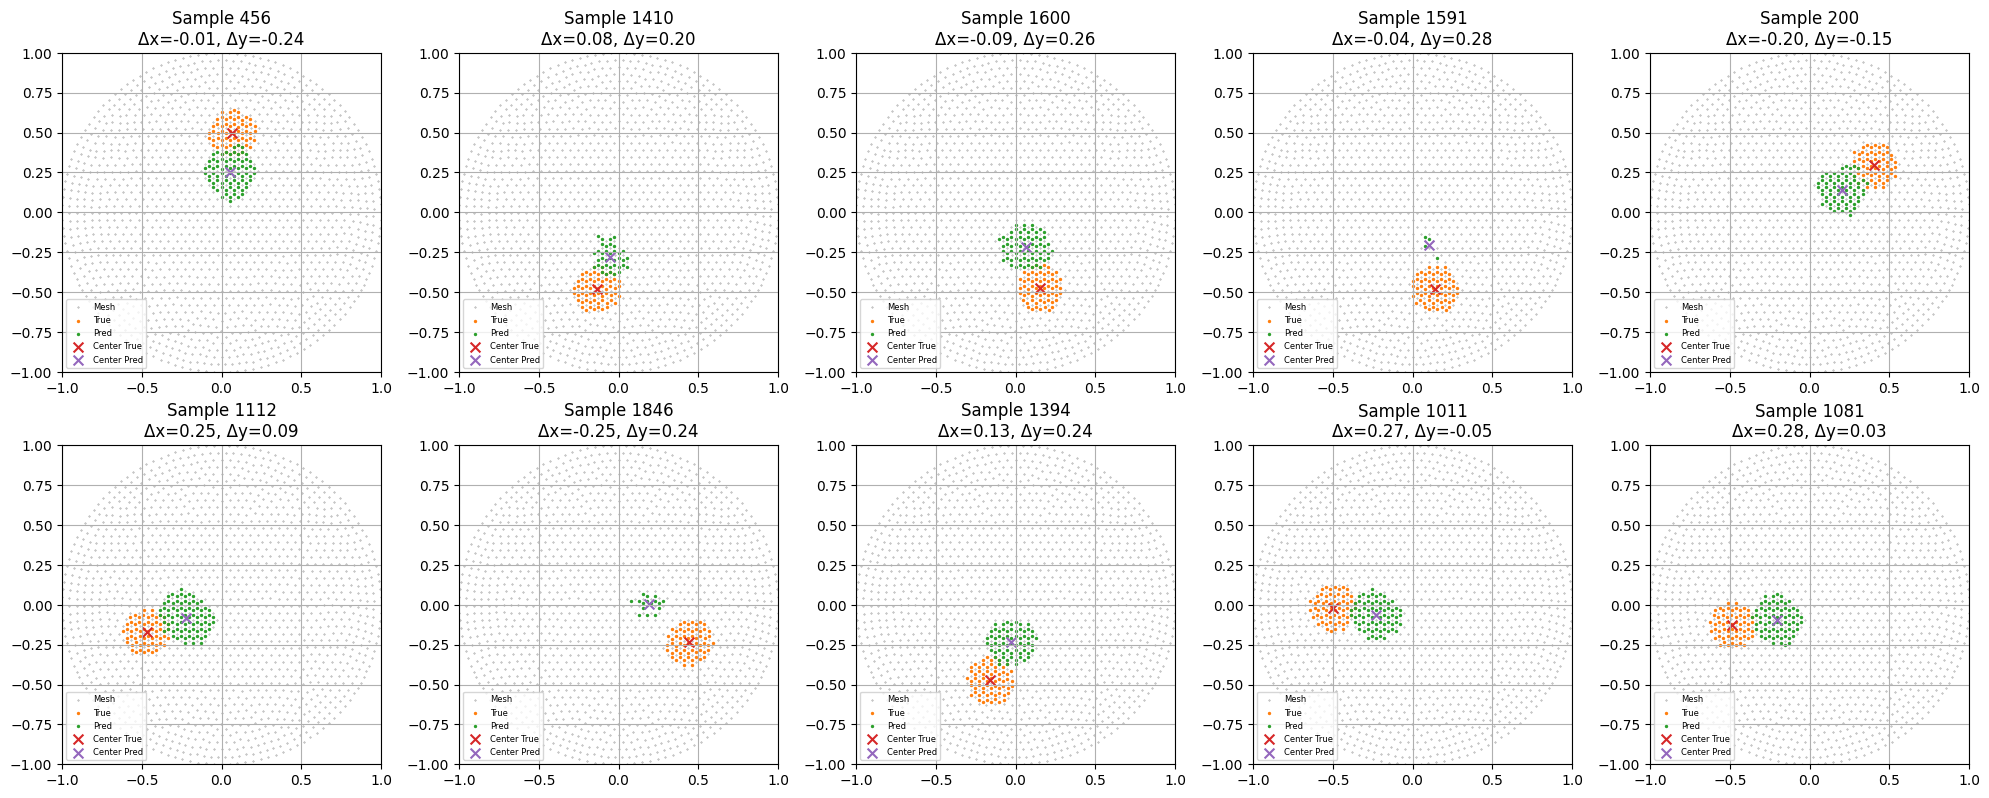

In [7]:
plot_random_deviations(mesh_obj, gamma_true_test, gamma_pred_test, num_samples=10, threshold=0.5, save=True, fpath='Abbildungen/',
                      fname='random_deviations_circle_interpol_sim_025_075.pdf')

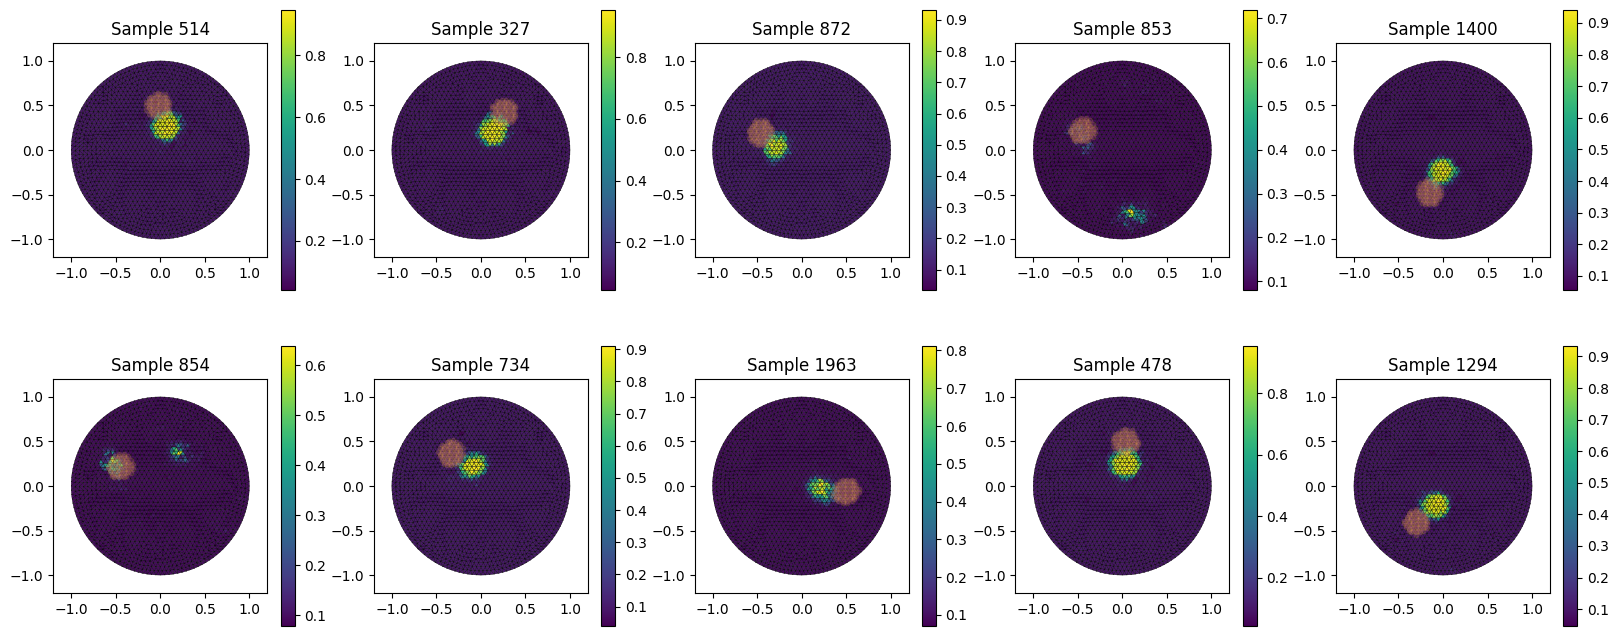

In [8]:
plot_random_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test, num_samples= 10)

Plot saved to: Abbildungen/position_sim_few_unbalanced_interpol_reconstruct_deviations.pdf
Statistics saved to: Abbildungen/perm_deviation_stats.txt
Merged analysis plots saved as: Abbildungen/combined_sim_few_unbalanced_interpol_reconstruct_deviations.pdf
Analysis complete. Final merged PDF saved as: Abbildungen/combined_sim_few_unbalanced_interpol_reconstruct_deviations.pdf


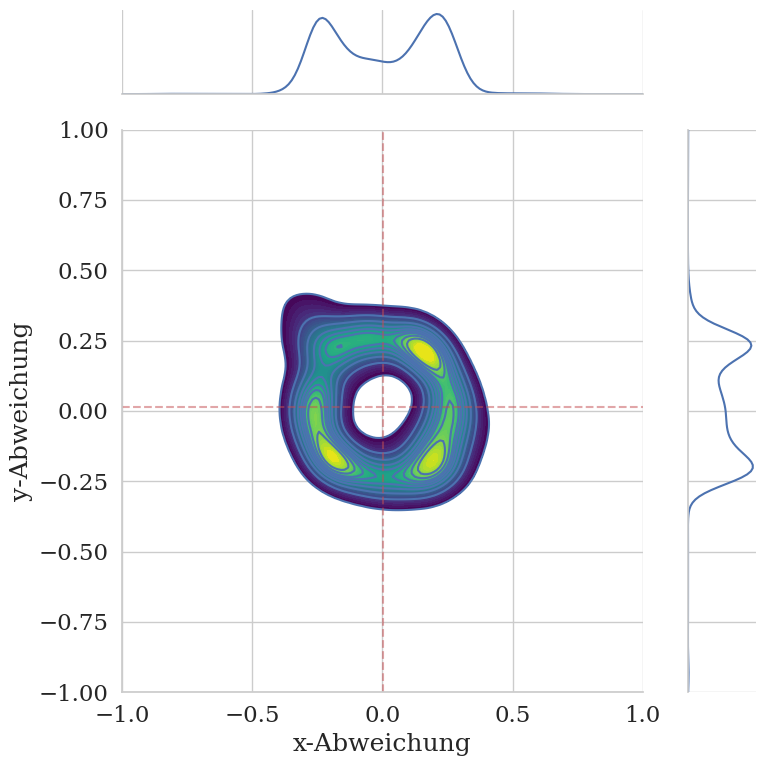

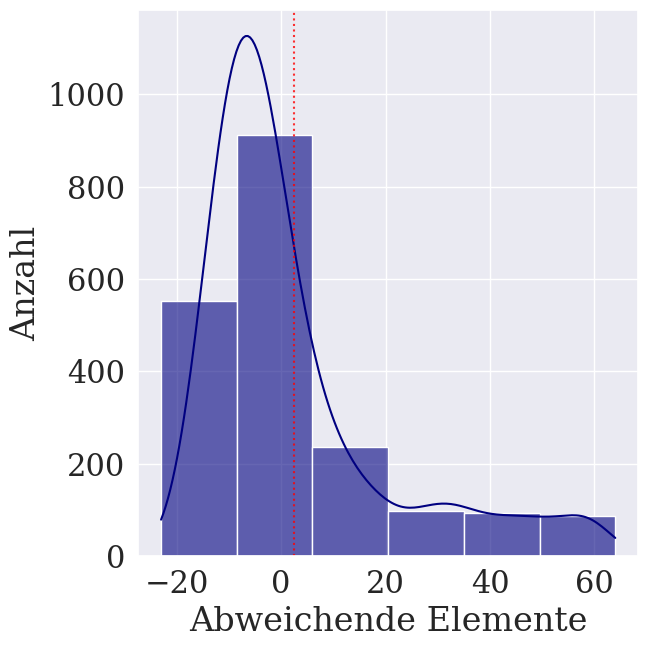

In [9]:
fpath = 'Abbildungen/'
base_fname = 'sim_few_unbalanced_interpol_reconstruct'

run_deviation_analysis(gamma_true_test, gamma_pred_test, mesh_obj, fpath, base_fname)